# Story 1

## Intro

Intro Text.

Based on https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/bulletins/deathsinvolvingcovid19bylocalareasanddeprivation/latest

### Data Sources

England and Wales ONS datasets:

- Mortality counts: https://www.ons.gov.uk/peoplepopulationandcommunity/healthandsocialcare/causesofdeath/datasets/deathregistrationsandoccurrencesbylocalauthorityandhealthboard
- IMD Rankings (England only): https://www.gov.uk/government/statistics/english-indices-of-deprivation-2019
- Populations: https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fpopulationandmigration%2fpopulationestimates%2fdatasets%2fpopulationestimatesforukenglandandwalesscotlandandnorthernireland%2fmid20182019laboundaries/ukmidyearestimates20182019ladcodes.xls

*Age-standardised mortality rates are presented per 100,000 people and standardised to the 2013 European Standard Population. Age-standardised mortality rates allow for differences in the age structure of populations and therefore allow valid comparisons to be made between geographical areas, the sexes and over time

# Setup & Data Collation

In [1]:
from datetime import datetime
import os
import requests

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

Set some data locations and make directories if needed.

In [2]:
# downloaded data goes here
downloaded_data_dir = 'data/downloaded'

# processed data goes here
derived_data_dirname = 'data/derived'

# create the directory if it does not already exist
os.makedirs(downloaded_data_dir, exist_ok=True)
os.makedirs(derived_data_dirname, exist_ok=True)

In [3]:
def download_file(url, filename):
        
    # create the directory if it does not already exist
    os.makedirs(os.path.dirname(filename), exist_ok=True)

    # make the HTTP request
    r = requests.get(url, allow_redirects=True)

    # save file
    _ = open(filename, 'wb').write(r.content)


## Index of Multiple Deprevation

### Download and Format

In [4]:
# specify URL
url = 'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/833970/File_1_-_IMD2019_Index_of_Multiple_Deprivation.xlsx'

# specify filename
filename = 'ONS_2019_Index_of_Multiple_Deprivation.xlsx'

# construct file path
filepath = os.path.join(downloaded_data_dir, filename)

# download and save file at the specified URL
download_file(url, filepath)

# read the relevant sheet
imd_df = pd.read_excel(filepath, sheet_name='IMD2019')

If we sort by deprivation rank, we can get an idea for the most / least deprived LSOAs.

In [5]:
imd_df.sort_values(by='Index of Multiple Deprivation (IMD) Rank')

,LSOA code (2011),LSOA name (2011),Local Authority District code (2019),Local Authority District name (2019),Index of Multiple Deprivation (IMD) Rank,Index of Multiple Deprivation (IMD) Decile
21400,E01021988,Tendring 018A,E07000076,Tendring,1,1
12280,E01012673,Blackpool 010A,E06000009,Blackpool,2,1
12288,E01012681,Blackpool 006A,E06000009,Blackpool,3,1
12279,E01012672,Blackpool 013B,E06000009,Blackpool,4,1
12278,E01012671,Blackpool 013A,E06000009,Blackpool,5,1
...,...,...,...,...,...,...
17759,E01018293,South Cambridgeshire 012B,E07000012,South Cambridgeshire,32840,10
15715,E01016187,Bracknell Forest 002D,E06000036,Bracknell Forest,32841,10
30976,E01031773,Mid Sussex 008D,E07000228,Mid Sussex,32842,10
26986,E01027699,Harrogate 021A,E07000165,Harrogate,32843,10


IMD table data has higher spatial resolution that the mortality data. We need to comibne the IMD rank to create a Local Authority District level rank. Let's construct a simple DataFrame that maps LAD code to mean IMD rank

### Derive Mean IMD Rank

In [6]:
def get_mean_IMD_rank(LAD_code):
    """
    TODO: map mean rank to [0,1] to make the number easier to understand.
    """
    # select relevant LSOAs
    LSOAs = imd_df[imd_df['Local Authority District code (2019)'] == LAD_code]
    
    # calculate mean IMD rank
    mean_IMD_rank = round(LSOAs['Index of Multiple Deprivation (IMD) Rank'].mean())
    
    return mean_IMD_rank

In [7]:
LAD_codes = imd_df['Local Authority District code (2019)'].unique()
mean_IMD_ranks = np.vectorize(get_mean_IMD_rank)(LAD_codes)

LAD_df = pd.DataFrame({'LAD Code': LAD_codes, 
                       'LAD Name': imd_df['Local Authority District name (2019)'].unique(),
                       'Mean IMD Rank': mean_IMD_ranks})

LAD_df = LAD_df.set_index('LAD Code')

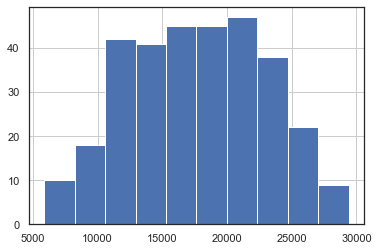

In [8]:
LAD_df['Mean IMD Rank'].hist()
plt.show()

As expected, we lose some information when aggregating IMD ranks in this way. The central part of the distribution is relatively flat, and we cannot differentiate well between LADs in this region.

### TODO: Derive Age Standardisation Weight

In [9]:
# TODO:
# derive age standardisation weight

# store the weight for each LAD in LAD_df

Let's save the `LAD_df` table we've created, so that we can easily use it as a lookup table. 

In [10]:
# create filename
LAD_df_filename = 'Local_Authority_District_Lookup.csv'
LAD_df_filepath = os.path.join(derived_data_dirname, LAD_df_filename)

# write to csv
LAD_df.to_csv(LAD_df_filepath, index=False)

## Mortality Counts

### Download and Format

First, let's download the ONS dataset containing mortality counts by week and local authority.

In [11]:
# specify URL
url = 'https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fhealthandsocialcare%2fcausesofdeath%2fdatasets%2fdeathregistrationsandoccurrencesbylocalauthorityandhealthboard%2f2020/lahbtablesweek20finalcodes.xlsx'

# specify filename
filename = 'ONS_COVID_Mortality_Counts.xlsx'

# construct file path
filepath = os.path.join (downloaded_data_dir, filename)

# download and save file at the specified URL
download_file(url, filepath)

In [12]:
# specify the sheet of the excel file we want to read
sheet_name = 'Registrations - All data'

# read the sheet into a pandas DataFrame
mortality_df = pd.read_excel(filepath, sheet_name=sheet_name, header=3)

Let's quickly check that we have 1:1 correspondence between LAD codes in the mortality dataset and in the IMD dataset.

In [13]:
print('Number of unique LAD Codes in mortality data =', len(mortality_df['Area code'].unique()))
print('Number of unique LAD Codes in IMD data =', len(imd_df['Local Authority District code (2019)'].unique()))

Number of unique LAD Codes in mortality data = 346
Number of unique LAD Codes in IMD data = 317


In [14]:
# extract those LAD codes which are present in the mortality dataset but not the IMD dataset
missing_LAD_codes_df = mortality_df[~mortality_df['Area code'].isin(imd_df['Local Authority District code (2019)'])]

missing_LAD_codes = missing_LAD_codes_df['Area code'].unique()

The IMD dataset does not contain any Welsh entries. We will have to drop Wales from the analysis for now.

In [15]:
mortality_df = mortality_df[~mortality_df['Area code'].isin(missing_LAD_codes)]

Let's take at a random sample of 5 rows in this DataFrame to get an idea of its structure.

In [16]:
mortality_df.sample(n=5)

,Area code,Geography type,Area name,Cause of death,Week number,Place of death,Number of deaths
21089,E06000030,Local Authority,Swindon,All causes,6,Other communal establishment,0
17762,E07000070,Local Authority,Chelmsford,All causes,5,Home,9
1731,E07000122,Local Authority,Pendle,All causes,1,Hospice,3
29085,E06000002,Local Authority,Middlesbrough,COVID 19,8,Hospice,0
41878,E06000032,Local Authority,Luton,COVID 19,11,Hospital,0


The dataset starts from the 1st Jan 2020. So let's convert the week number into a date.

In [17]:
# first day of 2020 is a Wednesday
mortality_df['Date'] = [datetime.strptime(f'2020 {n-1} 3', '%Y %W %w').strftime('%Y-%m-%d') 
                        for n in mortality_df['Week number']]

# might want to check these bounds match ONS end of week reporting
mortality_df = mortality_df[mortality_df['Date'] > '2020-03-01']
mortality_df = mortality_df[mortality_df['Date'] < '2020-04-18']

### Convert to Time Series

For now, let's sum the number of deaths over all places of death. It will also be useful to separate the "all causes" mortality counts and the "covid" mortality counts.

In [18]:
# sum over "Place of death" column
mortality_sum_df = mortality_df.groupby(by=['Area code', 'Date', 'Cause of death']).sum().reset_index()

# separate "all causes" and "covid" mortality counts
all_causes_df = mortality_sum_df[mortality_sum_df['Cause of death'] == 'All causes']
covid_df = mortality_sum_df[mortality_sum_df['Cause of death'] == 'COVID 19']

Create a new DataFrame, where we have an index corresponding to LAD Area code, and columns corresponding to dates. The entries in the DataFrame correspond to total number of deaths for that week in that LAD. Let's do this for all causes first.

In [19]:
# create new DataFrame
all_cause_mortality_ts_df = pd.DataFrame()
all_cause_mortality_ts_df.index.name = 'Area code'

# loop over all causes mortality summed DataFrame
for index, row in all_causes_df.iterrows():
    
    # if we haven't added this area code yet, add it now
    if index not in all_causes_df.index:
        all_cause_mortality_ts_df.loc[row['Area code']] = {}
    
    # add the mortality count
    all_cause_mortality_ts_df.loc[row['Area code'], row['Date']] = row['Number of deaths']

Same again for Covid deaths.

In [20]:
# create new DataFrame
covid_mortality_ts_df = pd.DataFrame()
covid_mortality_ts_df.index.name = 'Area code'

# loop over all causes mortality summed DataFrame
for index, row in covid_df.iterrows():
    
    # if we haven't added this area code yet, add it now
    if index not in covid_df.index:
        covid_mortality_ts_df.loc[row['Area code']] = {}
    
    # add the mortality count
    covid_mortality_ts_df.loc[row['Area code'], row['Date']] = row['Number of deaths']

In [21]:
covid_mortality_ts_df.head()

,2020-03-04,2020-03-11,2020-03-18,2020-03-25,2020-04-01,2020-04-08,2020-04-15
Area code,,,,,,,
E06000001,0.0,0.0,0.0,2.0,2.0,7.0,17.0
E06000002,0.0,0.0,0.0,0.0,20.0,32.0,33.0
E06000003,0.0,0.0,0.0,0.0,7.0,13.0,18.0
E06000004,0.0,0.0,1.0,1.0,6.0,7.0,21.0
E06000005,0.0,0.0,0.0,0.0,4.0,4.0,18.0


# Study 1

Make a simple plot of the number of deaths due to COVID 19 compared with all other deaths, by region. To do this, we'll need to download download a LAD code -> region lookup table from https://geoportal.statistics.gov.uk/datasets/local-authority-district-to-region-april-2019-lookup-in-england.

In [22]:
# specify URL
url = 'https://opendata.arcgis.com/datasets/3ba3daf9278f47daba0f561889c3521a_0.csv'

# specify filename
filename = 'LAD_Code_Region_Lookup.csv'

# construct file path
filepath = os.path.join (downloaded_data_dir, filename)

# download and save file at the specified URL
download_file(url, filepath)

# read the relevant sheet
LAD_code_region_lookup_df = pd.read_csv(filepath, index_col='FID').set_index('LAD19CD')

In [23]:
LAD_code_region_lookup_df.head()

,LAD19NM,RGN19CD,RGN19NM
LAD19CD,,,
E09000001,City of London,E12000007,London
E06000054,Wiltshire,E12000009,South West
E09000002,Barking and Dagenham,E12000007,London
E09000003,Barnet,E12000007,London
E09000004,Bexley,E12000007,London


Let's sum the mortality data over time to get the total number of deaths. Then, we'll reformat the DataFrame so we have columns for different causes of death. Finally, we'll use the above table to get the region name for each entry in the table.

In [24]:
# sum over time
total_deaths_df = mortality_sum_df.drop(columns='Week number').groupby(by=['Area code', 'Cause of death']).sum()
total_deaths_df = total_deaths_df.reset_index(level=[-1])

# seperate out All deaths and COVID deaths as their own columns
total_deaths_df = total_deaths_df.pivot(columns='Cause of death', values='Number of deaths')

# rename columns
total_deaths_df = total_deaths_df.rename(columns={'All causes': 'Total deaths', 'COVID 19': 'COVID deaths'})

# add non-COVID deaths as column
total_deaths_df['Non COVID deaths'] = total_deaths_df['Total deaths'] - total_deaths_df['COVID deaths']

# add area names
total_deaths_df['Area name'] = LAD_df.loc[total_deaths_df.index]['LAD Name']

# add region names
total_deaths_df['Region name'] = LAD_code_region_lookup_df.loc[total_deaths_df.index]['RGN19NM']

Summing over region and sorting the values, we are almost ready to make the plot.

In [25]:
# sum over LADs in each region
total_deaths_by_region_df = total_deaths_df.groupby(by='Region name').sum()

# sort ascending
total_deaths_by_region_df = total_deaths_by_region_df.sort_values(by='Total deaths', ascending=True)

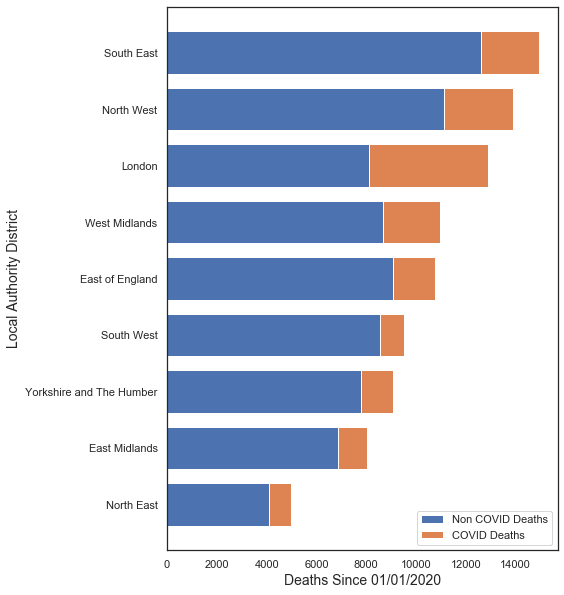

In [26]:
# region names
xs = total_deaths_by_region_df.index

# mortality counts
non_covid_deaths = total_deaths_by_region_df['Non COVID deaths']
covid_deaths = total_deaths_by_region_df['COVID deaths']

# set bar width
width = 0.75

# create a figure and plot data
plt.figure(figsize=(7,10))
p1 = plt.barh(xs, non_covid_deaths, width, label='Non COVID Deaths')
p2 = plt.barh(xs, covid_deaths, width, left=non_covid_deaths, label='COVID Deaths')

# label axes
plt.xlabel('Deaths Since 01/01/2020', fontsize=14)
plt.ylabel('Local Authority District', fontsize=14)

# show legend and plot
plt.legend()
plt.show()

This nicely reproduces Figure 1 from the following [ONS publication](https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/bulletins/deathsinvolvingcovid19bylocalareasanddeprivation/latest), and is a good sanity check of the data and code.